In [1]:
%load_ext tensorboard

In [2]:
import tensorflow as tf
import numpy as np
import tensorboard
print(tf.config.list_physical_devices())


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
mapping = [
           'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball bat', 'baseball',
           'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap',
           'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire',
           'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee_cup', 'compass', 'computer',
           'diamond', 'dishwasher', 'diving_board', 'dog', 'dolphin', 'donut', 'door', 'dragon', 'dresser', 'drill',
           'harp', 'hat', 'headphones', 'hedgehog', 'helicopter', 'helmet', 'hexagon', 'hockey_puck', 'hockey_stick', 'horse',
           'hospital', 'hot_air_balloon', 'hot_dog', 'hot_tub', 'hourglass', 'house_plant', 'house', 'hurricane', 'ice_cream', 'jacket',
           'paper_clip', 'parachute', 'parrot', 'passport', 'peanut', 'pear', 'peas', 'pencil', 'penguin', 'piano',
           'popsicle', 'postcard', 'potato', 'power_outlet', 'purse', 'rabbit', 'raccoon', 'radio', 'rain', 'rainbow',
           'trombone', 'truck', 'trumpet', 'umbrella', 'underwear', 'van', 'vase', 'violin', 'washing_machine', 'watermelon',
]

In [4]:
NUM_OBJECTS = 100

In [5]:
class Generator(tf.keras.utils.Sequence):
    def __init__(self,filenames,labels,batch_size,train=False):
        self.image_filenames = filenames
        self.labels = labels
        self.batch_size = batch_size
        self.train = train
        
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
  
  
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

        images = []
        for fname in batch_x:
            with open(fname,"rb") as f:
                images.append(np.divide(np.load(f),255.0))#normalize pixel values
        return np.array(images), np.array(batch_y)

In [6]:
!pip install scikit-learn

In [7]:
from sklearn.model_selection import train_test_split

filenames = []
labels = []
for lab in range(NUM_OBJECTS):
    labels += [lab for _ in range(10_000)]
    for i in range(10_000):
        filenames.append(f"dataset/images/{lab}/{i}.npy")

labels = tf.keras.utils.to_categorical(labels)


train_X,test_X,train_y,test_y = train_test_split(filenames,labels,test_size=0.1)

train_X,val_X,train_y,val_y = train_test_split(train_X,train_y,test_size=0.22)

train_gen = Generator(train_X,train_y,50)
val_gen = Generator(val_X,val_y,10)

In [8]:
def get_model(input_shape,num_outputs):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(16,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
        tf.keras.layers.Conv2D(16,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024,activation="relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256,activation="relu"),
        tf.keras.layers.Dense(num_outputs,activation="softmax") #probability distribution output
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics="accuracy"
    )
    model.build()
    return model

In [9]:
model = get_model((64,64,1),NUM_OBJECTS)

In [10]:
from datetime import datetime
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [11]:
model.fit(train_gen,
          epochs=50,
          validation_data=val_gen,
          callbacks=[
              tf.keras.callbacks.ReduceLROnPlateau(
                  monitor='val_accuracy', 
                  patience=3,
                  min_delta=0.0001,
                  factor=0.25,
                  min_lr=0.000001
                ),
              tf.keras.callbacks.EarlyStopping(
                  monitor='val_accuracy', 
                  patience=6, 
                  verbose=2,
                  mode='max',
                  restore_best_weights=True
                ),
              tf.keras.callbacks.ModelCheckpoint(
                     filepath='C:\\Users\\Jake\\Desktop\\ai-playground\\doodle-detection\\models\\model_best.h5', 
                     save_freq='epoch', verbose=1, monitor='val_accuracy', mode="max",
                     save_weights_only=True, save_best_only=True
                ),
              tensorboard_callback
          ])

Epoch 1/50


14040/14040 [==============================] - ETA: 0s - loss: 1.8746 - accuracy: 0.5300
Epoch 1: val_accuracy improved from -inf to 0.66509, saving model to C:\Users\Jake\Desktop\ai-playground\doodle-detection\models\model_best.h5
14040/14040 [==============================] - 1173s 83ms/step - loss: 1.8746 - accuracy: 0.5300 - val_loss: 1.2892 - val_accuracy: 0.6651 - lr: 1.0000e-04
Epoch 2/50
14040/14040 [==============================] - ETA: 0s - loss: 1.3049 - accuracy: 0.6604
Epoch 2: val_accuracy improved from 0.66509 to 0.70811, saving model to C:\Users\Jake\Desktop\ai-playground\doodle-detection\models\model_best.h5
14040/14040 [==============================] - 1002s 71ms/step - loss: 1.3049 - accuracy: 0.6604 - val_loss: 1.1184 - val_accuracy: 0.7081 - lr: 1.0000e-04
Epoch 3/50
14040/14040 [==============================] - ETA: 0s - loss: 1.1597 - accuracy: 0.6954
Epoch 3: val_accuracy improved from 0.70811 to 0.72662, saving model to C:\Users\Jake\Desktop\ai-

In [12]:
model.load_weights('C:\\Users\\Jake\\Desktop\\ai-playground\\doodle-detection\\models\\model_best.h5')

In [13]:
model.evaluate(Generator(test_X,test_y,10))

10000/10000 [==============================] - 74s 7ms/step - loss: 0.9708 - accuracy: 0.7697


[0.9707586765289307, 0.7696800231933594]

In [14]:
model.save('C:\\Users\\Jake\\Desktop\\ai-playground\\doodle-detection\\models\\model_100obj.h5')

c:\Users\Jake\anaconda3\envs\ai-project\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


(64, 64, 1)


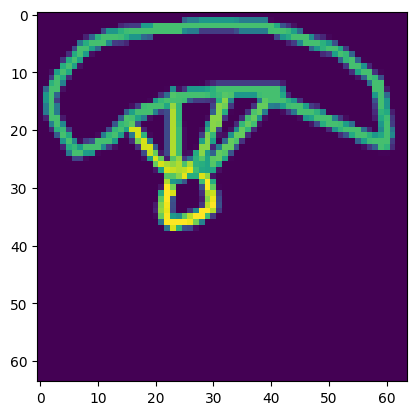

1/1 [==============================] - 0s 39ms/step
TRUE: parachute,PREDICT: parachute, 99.99%
(64, 64, 1)


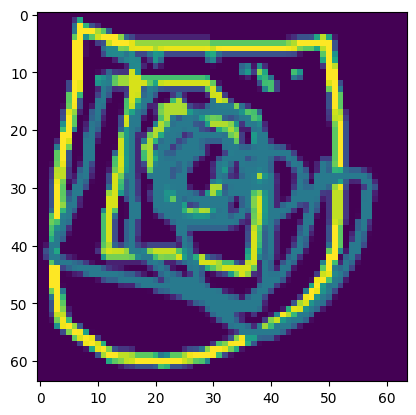

1/1 [==============================] - 0s 45ms/step
TRUE: dishwasher,PREDICT: dishwasher, 93.73%
(64, 64, 1)


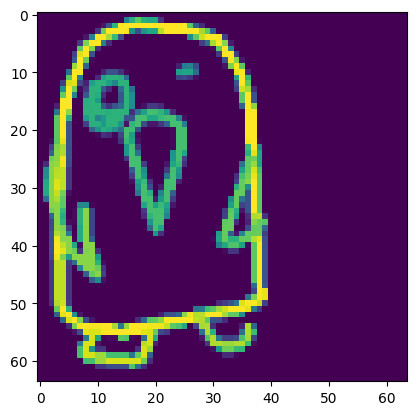

1/1 [==============================] - 0s 34ms/step
TRUE: penguin,PREDICT: penguin, 99.94%
(64, 64, 1)


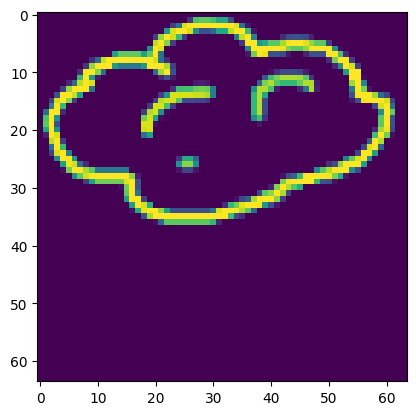

1/1 [==============================] - 0s 36ms/step
TRUE: cloud,PREDICT: bush, 77.51%
(64, 64, 1)


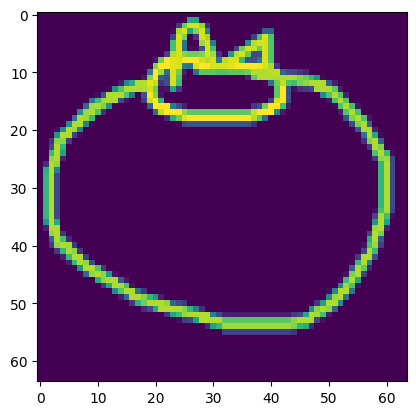

1/1 [==============================] - 0s 35ms/step
TRUE: blueberry,PREDICT: blueberry, 99.02%
(64, 64, 1)


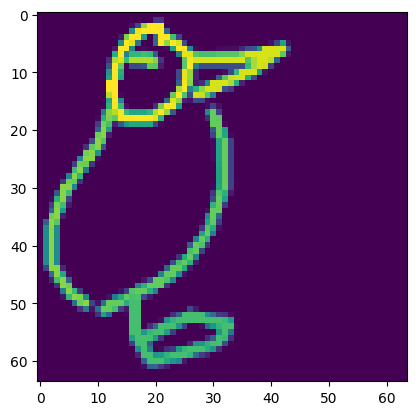

1/1 [==============================] - 0s 55ms/step
TRUE: penguin,PREDICT: penguin, 73.02%
(64, 64, 1)


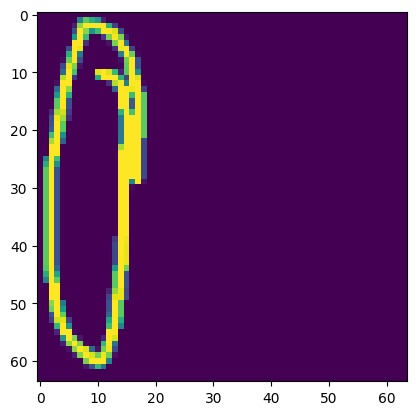

1/1 [==============================] - 0s 41ms/step
TRUE: paper_clip,PREDICT: paper_clip, 98.33%
(64, 64, 1)


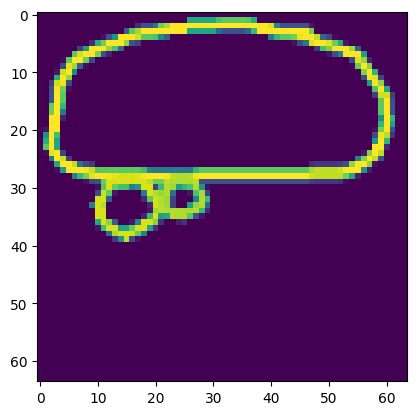

1/1 [==============================] - 0s 35ms/step
TRUE: van,PREDICT: van, 99.05%
(64, 64, 1)


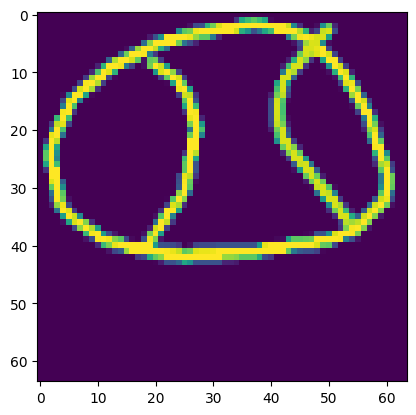

1/1 [==============================] - 0s 36ms/step
TRUE: baseball,PREDICT: baseball, 99.97%
(64, 64, 1)


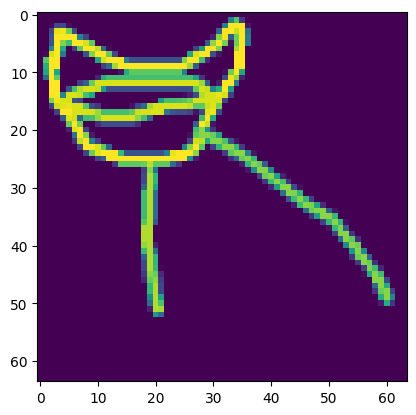

1/1 [==============================] - 0s 38ms/step
TRUE: raccoon,PREDICT: raccoon, 99.35%
(64, 64, 1)


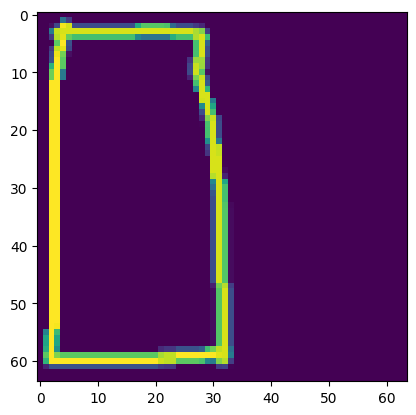

1/1 [==============================] - 0s 74ms/step
TRUE: door,PREDICT: door, 99.76%
(64, 64, 1)


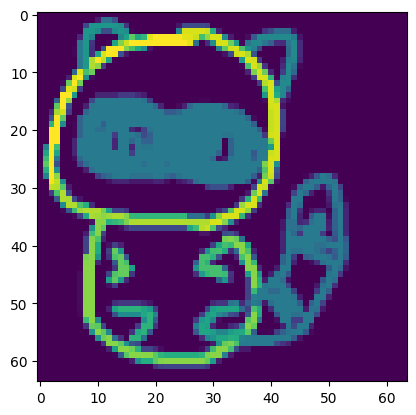

1/1 [==============================] - 0s 38ms/step
TRUE: raccoon,PREDICT: raccoon, 59.6%
(64, 64, 1)


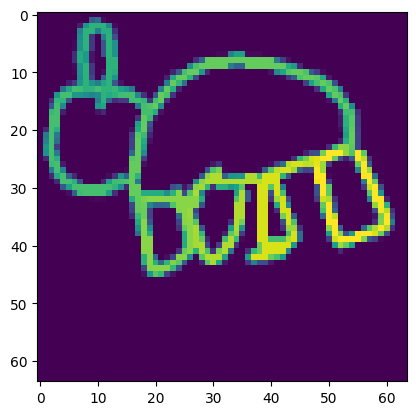

1/1 [==============================] - 0s 35ms/step
TRUE: dog,PREDICT: dog, 94.07%
(64, 64, 1)


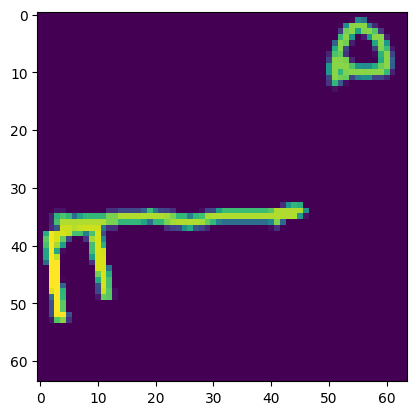

1/1 [==============================] - 0s 36ms/step
TRUE: diving_board,PREDICT: diving_board, 38.06%
(64, 64, 1)


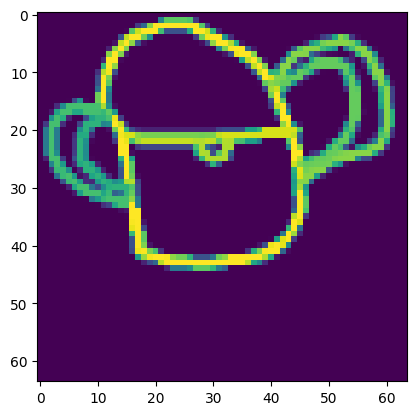

1/1 [==============================] - 0s 35ms/step
TRUE: backpack,PREDICT: backpack, 83.01%
(64, 64, 1)


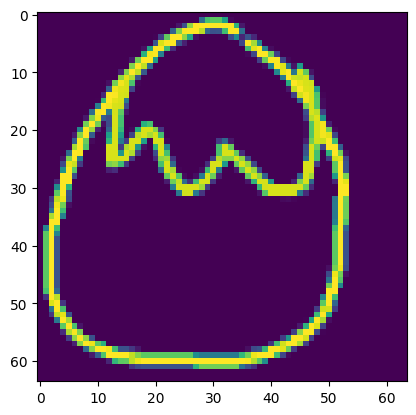

1/1 [==============================] - 0s 45ms/step
TRUE: blueberry,PREDICT: blueberry, 92.12%
(64, 64, 1)


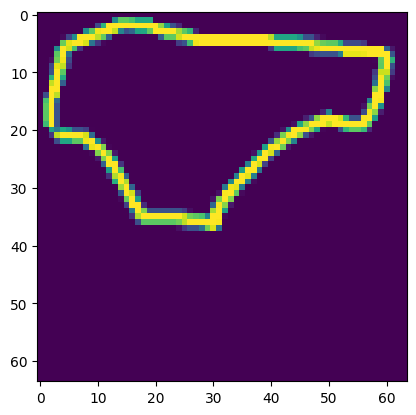

1/1 [==============================] - 0s 38ms/step
TRUE: underwear,PREDICT: underwear, 99.96%
(64, 64, 1)


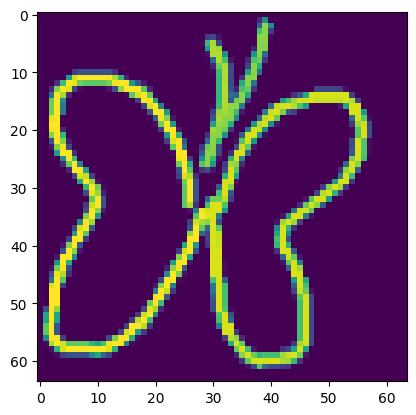

1/1 [==============================] - 0s 40ms/step
TRUE: butterfly,PREDICT: butterfly, 100.0%
(64, 64, 1)


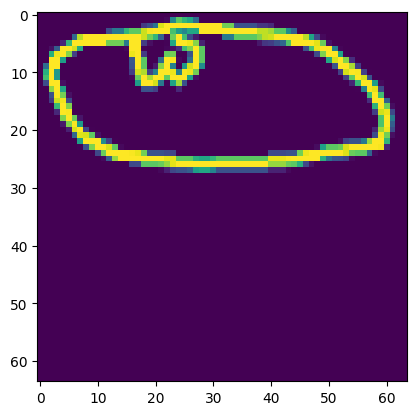

1/1 [==============================] - 0s 50ms/step
TRUE: blueberry,PREDICT: bush, 39.46%
(64, 64, 1)


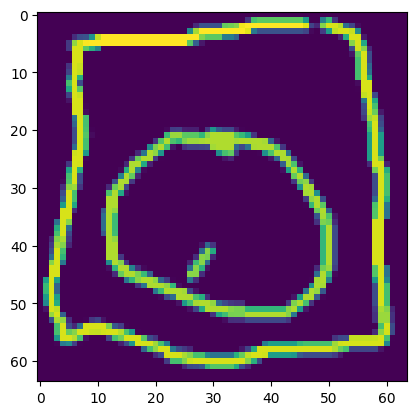

1/1 [==============================] - 0s 93ms/step
TRUE: washing_machine,PREDICT: washing_machine, 97.33%
(64, 64, 1)


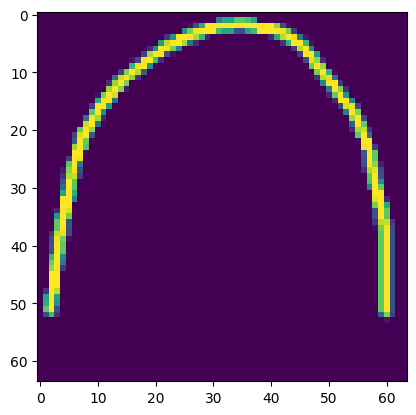

1/1 [==============================] - 0s 42ms/step
TRUE: rainbow,PREDICT: rainbow, 99.53%
(64, 64, 1)


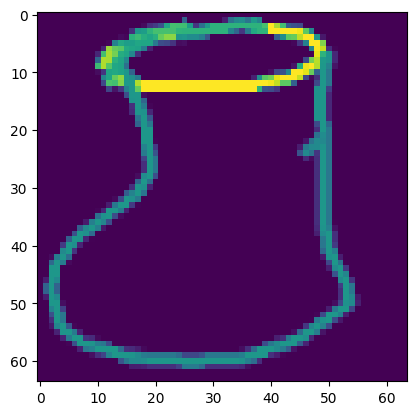

1/1 [==============================] - 0s 38ms/step
TRUE: vase,PREDICT: bottlecap, 80.47%
(64, 64, 1)


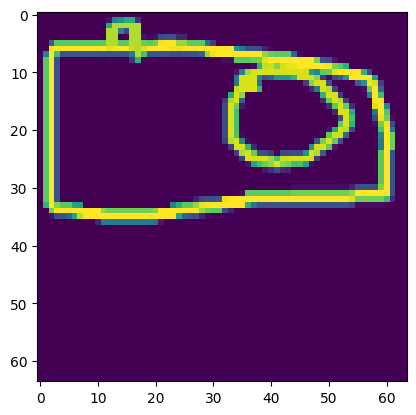

1/1 [==============================] - 0s 37ms/step
TRUE: camera,PREDICT: camera, 99.96%
(64, 64, 1)


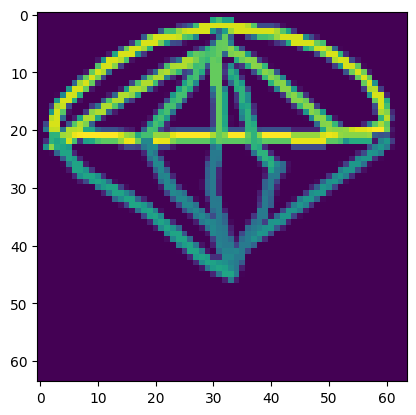

1/1 [==============================] - 0s 44ms/step
TRUE: parachute,PREDICT: parachute, 99.96%
(64, 64, 1)


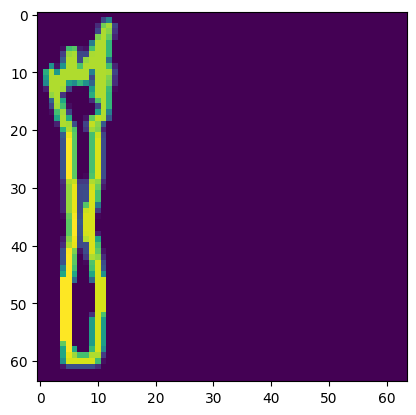

1/1 [==============================] - 0s 37ms/step
TRUE: asparagus,PREDICT: asparagus, 99.98%
(64, 64, 1)


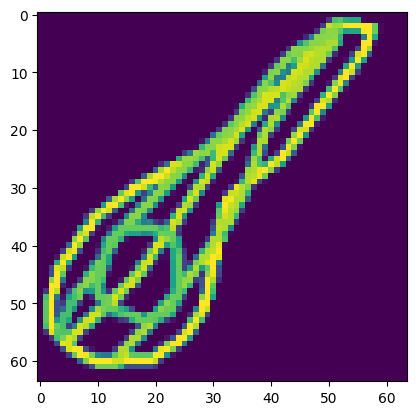

1/1 [==============================] - 0s 35ms/step
TRUE: violin,PREDICT: violin, 99.91%
(64, 64, 1)


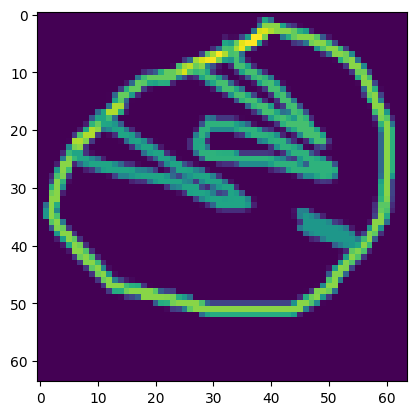

1/1 [==============================] - 0s 38ms/step
TRUE: watermelon,PREDICT: clock, 45.29%
(64, 64, 1)


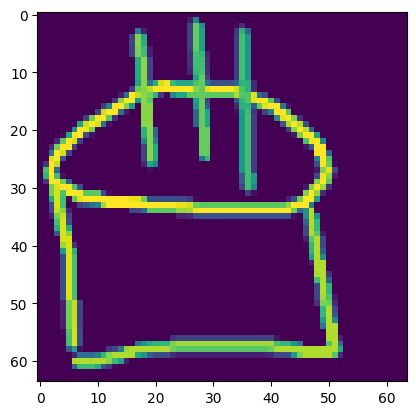

1/1 [==============================] - 0s 41ms/step
TRUE: birthday cake,PREDICT: birthday cake, 53.72%
(64, 64, 1)


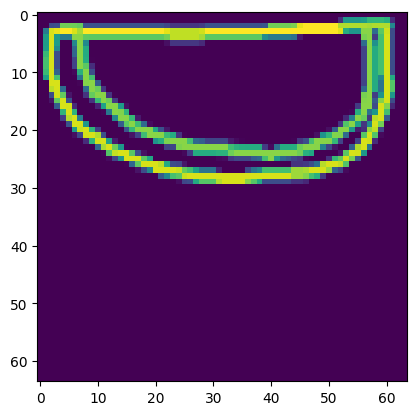

1/1 [==============================] - 0s 36ms/step
TRUE: watermelon,PREDICT: watermelon, 99.94%
(64, 64, 1)


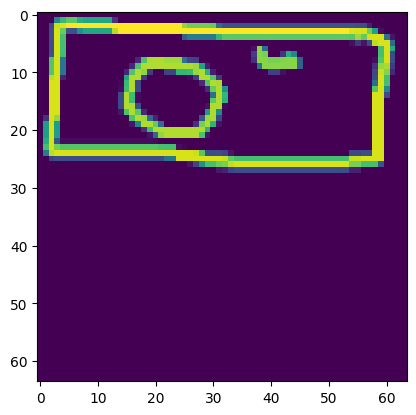

1/1 [==============================] - 0s 37ms/step
TRUE: camera,PREDICT: camera, 99.86%
(64, 64, 1)


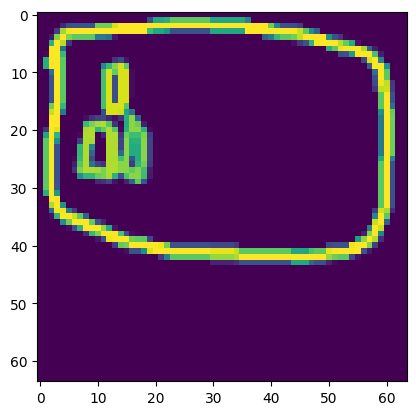

1/1 [==============================] - 0s 54ms/step
TRUE: power_outlet,PREDICT: power_outlet, 28.89%
(64, 64, 1)


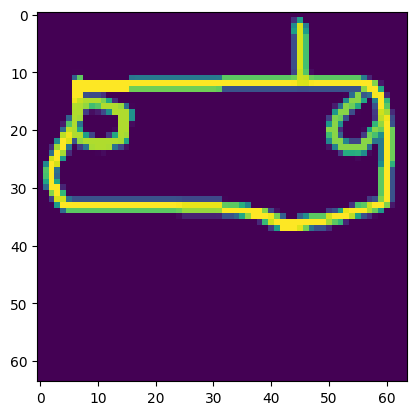

1/1 [==============================] - 0s 41ms/step
TRUE: radio,PREDICT: birthday cake, 89.27%
(64, 64, 1)


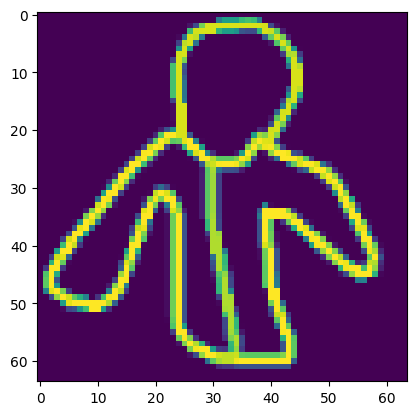

1/1 [==============================] - 0s 38ms/step
TRUE: jacket,PREDICT: jacket, 99.85%
(64, 64, 1)


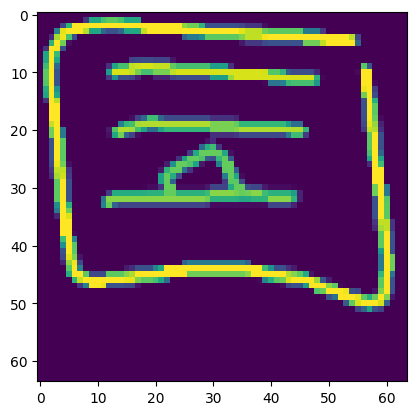

1/1 [==============================] - 0s 36ms/step
TRUE: dishwasher,PREDICT: dresser, 77.29%
(64, 64, 1)


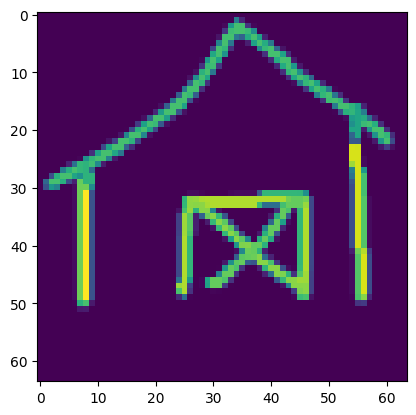

1/1 [==============================] - 0s 38ms/step
TRUE: barn,PREDICT: barn, 97.25%
(64, 64, 1)


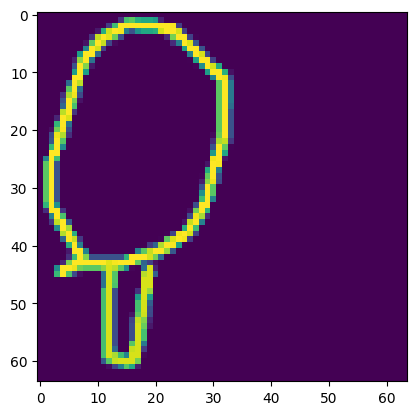

1/1 [==============================] - 0s 39ms/step
TRUE: popsicle,PREDICT: popsicle, 99.96%
(64, 64, 1)


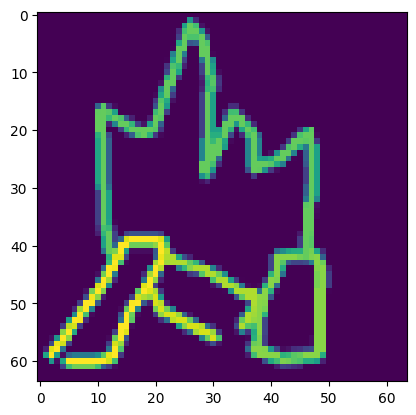

1/1 [==============================] - 0s 38ms/step
TRUE: campfire,PREDICT: campfire, 98.76%
(64, 64, 1)


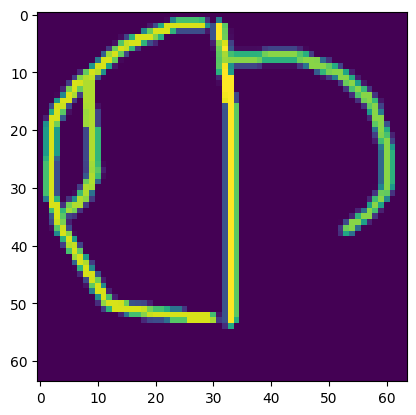

1/1 [==============================] - 0s 37ms/step
TRUE: backpack,PREDICT: backpack, 66.97%
(64, 64, 1)


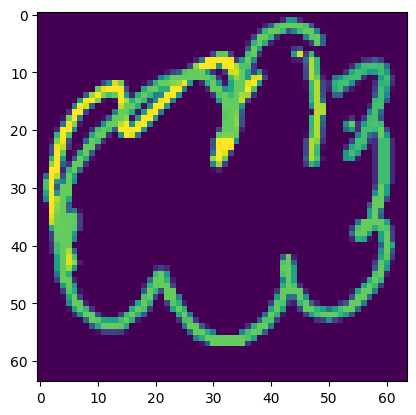

1/1 [==============================] - 0s 35ms/step
TRUE: bush,PREDICT: camel, 93.04%
(64, 64, 1)


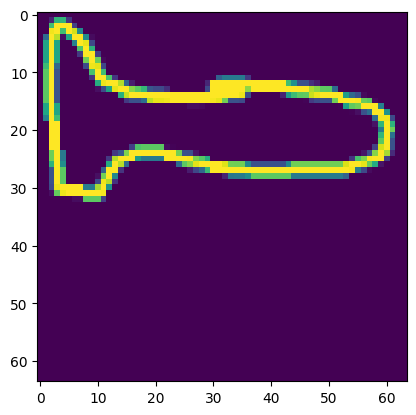

1/1 [==============================] - 0s 35ms/step
TRUE: trumpet,PREDICT: trumpet, 98.43%
(64, 64, 1)


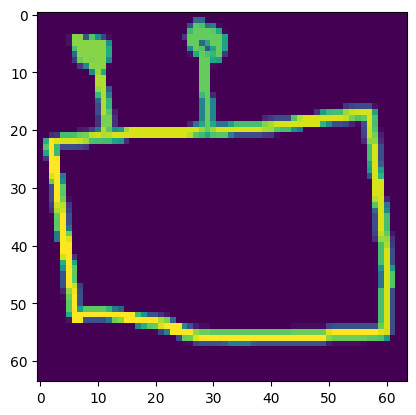

1/1 [==============================] - 0s 35ms/step
TRUE: cake,PREDICT: birthday cake, 83.75%
(64, 64, 1)


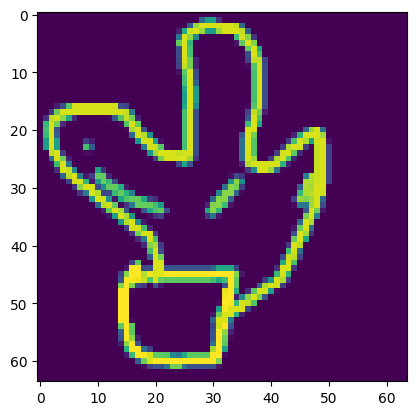

1/1 [==============================] - 0s 39ms/step
TRUE: cactus,PREDICT: cactus, 100.0%
(64, 64, 1)


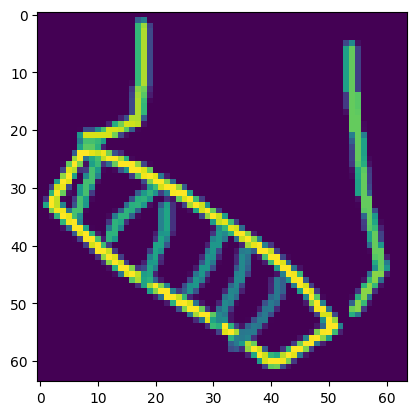

1/1 [==============================] - 0s 97ms/step
TRUE: piano,PREDICT: binoculars, 41.67%
(64, 64, 1)


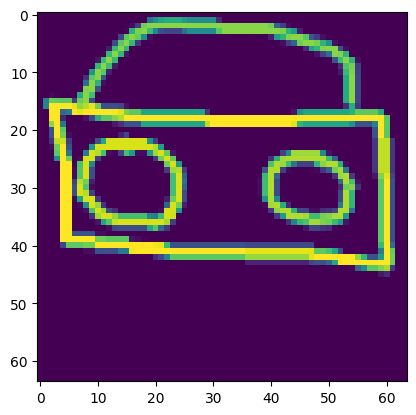

1/1 [==============================] - 0s 50ms/step
TRUE: radio,PREDICT: radio, 100.0%
(64, 64, 1)


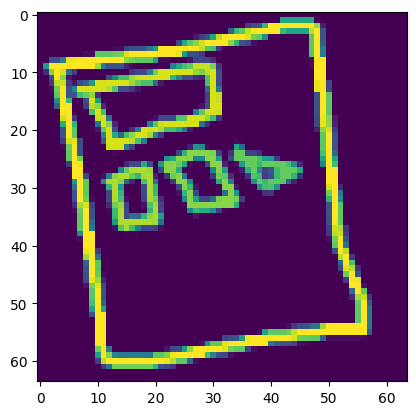

1/1 [==============================] - 0s 73ms/step
TRUE: calculator,PREDICT: calculator, 99.95%
(64, 64, 1)


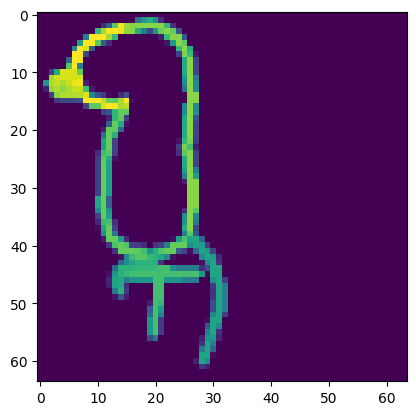

1/1 [==============================] - 0s 51ms/step
TRUE: parrot,PREDICT: parrot, 95.69%
(64, 64, 1)


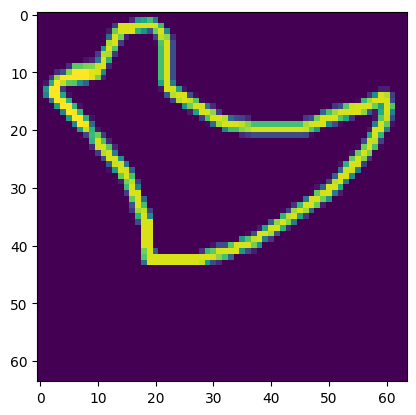

1/1 [==============================] - 0s 36ms/step
TRUE: bird,PREDICT: bird, 98.81%
(64, 64, 1)


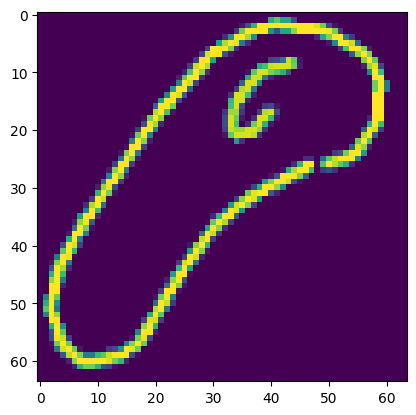

1/1 [==============================] - 0s 37ms/step
TRUE: peanut,PREDICT: peanut, 94.84%
(64, 64, 1)


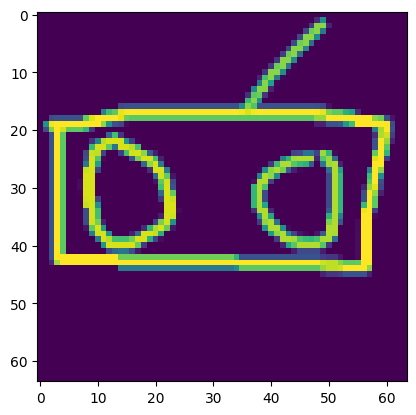

1/1 [==============================] - 0s 35ms/step
TRUE: radio,PREDICT: radio, 100.0%
(64, 64, 1)


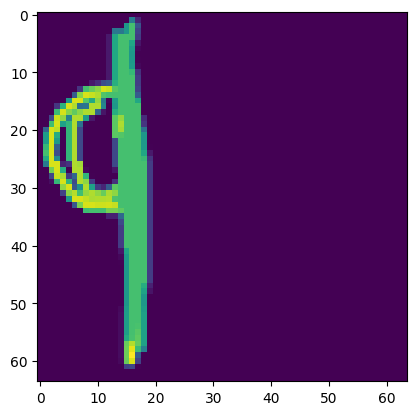

1/1 [==============================] - 0s 38ms/step
TRUE: axe,PREDICT: asparagus, 69.87%


In [16]:
from matplotlib import pyplot as plt


for i in range(50):
    fname = test_X[i]
    img = None
    with open(fname,"rb") as f:
        img = np.divide(np.load(f),255.0)
    print(img.shape)
    plt.imshow(img, interpolation='nearest')
    plt.show()
    
    label = np.argmax(test_y[i])
    pred = model.predict(Generator([fname],[label],1))[0]
    pred_label = np.argmax(pred)
    perc = pred[pred_label]
    print(f'TRUE: {mapping[label]},PREDICT: {mapping[pred_label]}, {round(perc*100,2)}%')
    
